In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the custom model class
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(8, 8)
        self.relu = nn.Sigmoid()
        self.fc3 = nn.Linear(8, 2)
        # self.relu = nn.ReLU()
        # self.fc4 = nn.Linear(hidden_size, hidden_size)
        # self.relu = nn.ReLU()
        # self.fc5 = nn.Linear(hidden_size, hidden_size)
        # self.relu = nn.ReLU()
        # self.fc6 = nn.Linear(hidden_size, output_size)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        # out = self.relu(out)
        # out = self.fc5(out)
        # out = self.relu(out)
        # out = self.fc6(out)
        # out = self.softmax(out)
        return out


# Define the training function
# def train(model, train_data, num_epochs, learning_rate):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     for epoch in range(num_epochs):
#         for i, (inputs, labels) in enumerate(train_data):
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             if (i+1) % 100 == 0:
#                 print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                       .format(epoch+1, num_epochs, i+1, len(train_data), loss.item()))


class Toy_Dataset(Dataset):
    def __init__(self, data, label=None):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.len = len(self.data)
        if type(label) == type(None):
            self.label = None
        else:
            self.label = label
        
    def __getitem__(self, idx):
        if type(self.label) == type(None):
            self.ua_data = self.data + torch.rand(self.len, 2)/5.
            return self.data[idx], self.ua_data[idx]
        else:
            self.label = torch.tensor(self.label, dtype=torch.long)
            return self.data[idx], self.label[idx]
    
    def __len__(self):
        return self.len


class Params():
    def __init__(self):
        self.uda_temp = 0.75
        self.uda_threshold = 0.6
        self.train_batch_size = 30
        self.uda_data = 1


def meta_pseudo_labels_step(teacher_model, 
                            teacher_optimizer, 
                            student_model, 
                            student_optimizer, 
                            u_image,
                            ua_image,
                            l_image, 
                            l_label,
                            step_num,
                            params=Params()):
    teacher_optimizer.zero_grad()
    student_optimizer.zero_grad()
    
    image = {}
    image['u'] = u_image
    image['ua'] = ua_image
    image['l'] = l_image
    
    label = {}
    label['l'] = l_label
    
    logit = {} # 순수 logit임! softmax 아님~~~
    
    loss_fn = nn.CrossEntropyLoss()
    loss = {}
    
    ##### teacher UDA loss #####
    logit['t_on_u'] = teacher_model(image['u'])
    label['ua'] = nn.functional.softmax(logit['t_on_u'] / params.uda_temp, dim=-1)
    label['ua'] = label['ua'].detach()
    label['ua'].requires_grad = False
    
    logit['t_on_ua'] = teacher_model(image['ua'])
    loss['t_on_ua'] = torch.mul(label['ua'], nn.functional.log_softmax(logit['t_on_ua'], dim=-1))
    largest_probs, _ = torch.max(label['ua'], axis=-1, keepdim=True)
    mask = torch.greater_equal(largest_probs, params.uda_threshold).type(torch.float32)
    
    loss['t_on_ua'] = torch.mean(torch.mul(-loss['t_on_ua'], mask)) #/ float(params.train_batch_size*params.uda_data)
    
    
    ##### teacher CE loss #####
    logit['t_on_l'] = teacher_model(image['l'])
    loss['t_on_l'] = loss_fn(nn.functional.softmax(logit['t_on_l'], dim=-1), label['l'])
    
    
    ##### student performance old #####
    logit['s_on_l_old'] = student_model(image['l'])
    loss['s_on_l_old'] = loss_fn(nn.functional.softmax(logit['s_on_l_old'], dim=-1), label['l'])
    loss['s_on_l_old'] = loss['s_on_l_old'].detach()
    loss['s_on_l_old'].requires_grad = False
    
    
    ##### student CE loss #####
    logit['s_on_ua'] = student_model(image['ua'])
    loss['s_on_ua'] = loss_fn(nn.functional.softmax(logit['s_on_ua'], dim=-1), torch.argmax(label['ua'], -1).long()) # 이 부분이 소프트레이블이 될수도 있음(논문은 소프트 하드 둘다해봤다함)
    
    
    ##### student update #####
    student_optimizer.zero_grad()
    loss['s_on_ua'].backward()
    student_optimizer.step()
    
    
    ##### student performance new #####
    logit['s_on_l_new'] = student_model(image['l'])
    loss['s_on_l_new'] = loss_fn(nn.functional.softmax(logit['s_on_l_new'], dim=-1), label['l'])
    loss['s_on_l_new'] = loss['s_on_l_new'].detach()
    loss['s_on_l_new'].requires_grad = False
    
    
    ##### prepare feedback for teacher #####
    dot_product = (loss['s_on_l_new'] - loss['s_on_l_old'])
    # dot_product = dot_product / abs(dot_product)
    # temp = nn.functional.softmax(logit['t_on_ua'], dim=-1).clone().detach()
    # temp.requires_grad = False
    # loss['mpl'] = -torch.mean(torch.mul(temp, nn.functional.log_softmax(logit['t_on_ua'], dim=-1))) # 자기 자신으로부터 크로스엔트로피 구함
    loss['mpl'] = -torch.mean(torch.mul(torch.argmax(nn.functional.softmax(logit['t_on_ua'], dim=-1), -1, keepdim=True), nn.functional.log_softmax(logit['t_on_ua'], dim=-1))) # 자기 자신으로부터 크로스엔트로피 구함
    loss['mpl'] = loss['mpl'] * dot_product #* torch.abs(torch.cos(torch.tensor(step_num)))


    ##### teacher update #####
    teacher_optimizer.zero_grad()
    # if abs(loss['mpl']) > 0.1:
    #     loss['mpl'] = (loss['mpl'] / loss['mpl']) * 0.1
    teacher_loss = loss['t_on_l'] + loss['t_on_ua'] + loss['mpl']
    teacher_loss.backward()
    
    teacher_optimizer.step()
    
    return teacher_loss.detach().numpy(), loss['s_on_ua'].detach().numpy(), loss['mpl'].detach().numpy()



/home/dbnt-ws-02/anaconda3/envs/torch18/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import copy

In [3]:
u_x, u_y = make_moons(n_samples=500, noise=0.1)

In [4]:
l_x = np.array([[-1, 0.25], [0.5, 0.8], [0.9, 0.05], [0.9, -0.5], [1.2, -0.4], [1.85, 0.25]])
l_y = np.array([0,0,0,1,1,1])

In [255]:
# l_x = np.array([[-1, 0.25], [-0.7, 0.75], [1.0, 0.4], [2.0, 0.35], [1.6, -0.1], [0.1, -0.1]])
# l_y = np.array([0,0,0,1,1,1])

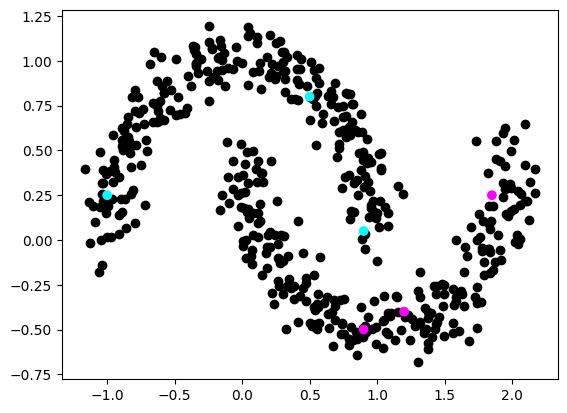

In [5]:
plt.scatter(u_x[:, 0], u_x[:, 1], c='black')
plt.scatter(l_x[:, 0], l_x[:, 1], c=l_y, cmap=plt.cm.cool)
plt.show()

In [6]:
unlabeled_dataset = Toy_Dataset(u_x)
labeled_dataset = Toy_Dataset(l_x, l_y)

unlabeled_dataloader = DataLoader(dataset=unlabeled_dataset, batch_size=500, shuffle=True)
labeled_dataloader = DataLoader(dataset=labeled_dataset, batch_size=6, shuffle=True)

In [7]:
unlabeled_iterator = unlabeled_dataloader.__iter__()
labeled_iterator = labeled_dataloader.__iter__()


teacher_model = MyModel(2, 8, 2)
student_model = MyModel(2, 8, 2)

teacher_model.train(True)
student_model.train(True)

teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=2e-1)
student_optimizer = optim.Adam(student_model.parameters(), lr=2e-1)

step = 0
best_acc = 0.8
while(True):
    try:
        u_image, ua_image = unlabeled_iterator.__next__()
    except:
        unlabeled_iterator = unlabeled_dataloader.__iter__()
        u_image, ua_image = unlabeled_iterator.__next__()
    
    try:
        l_image, l_label = labeled_iterator.__next__()
    except:
        labeled_iterator = labeled_dataloader.__iter__()
        l_image, l_label = labeled_iterator.__next__()
    
    teacher_model.train(True)
    student_model.train(True)
    aa = meta_pseudo_labels_step(teacher_model, 
                                teacher_optimizer, 
                                student_model, 
                                student_optimizer, 
                                u_image,
                                ua_image,
                                l_image, 
                                l_label,
                                step,
                                params=Params())
    
    teacher_model.train(False)
    student_model.train(False)
    infer = teacher_model(torch.tensor(u_x).type(torch.float32))
    teacher_acc = sum((torch.argmax(infer, -1).numpy() == u_y).astype(int))/500
    
    infer = student_model(torch.tensor(u_x).type(torch.float32))
    student_acc = sum((torch.argmax(infer, -1).numpy() == u_y).astype(int))/500
    
    print(f'teacher_loss : {round(float(aa[0]), 4)}, student_loss : {round(float(aa[1]), 4)}, teacher_acc : {round(float(teacher_acc), 4)}, student_acc : {round(float(student_acc), 4)}, best_acc : {round(float(best_acc), 4)}, mpl_loss : {round(float(aa[2]), 4)}')
    
    if student_acc > best_acc:
        best_acc = student_acc
        best_student_model = copy.deepcopy(student_model)
    
    if float(student_acc) > 0.99:
        break
    
    step += 1
    if step == 10000:
        break



/tmp/ipykernel_10585/377096084.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label = torch.tensor(self.label, dtype=torch.long)


teacher_loss : 1.0523, student_loss : 0.712, teacher_acc : 0.5, student_acc : 0.5, best_acc : 0.8, mpl_loss : 0.0527
teacher_loss : 0.947, student_loss : 1.1446, teacher_acc : 0.5, student_acc : 0.5, best_acc : 0.8, mpl_loss : -0.0
teacher_loss : 0.9282, student_loss : 1.1554, teacher_acc : 0.5, student_acc : 0.5, best_acc : 0.8, mpl_loss : 0.0
teacher_loss : 0.9412, student_loss : 1.0937, teacher_acc : 0.5, student_acc : 0.5, best_acc : 0.8, mpl_loss : 0.0
teacher_loss : 0.8481, student_loss : 0.9832, teacher_acc : 0.816, student_acc : 0.5, best_acc : 0.8, mpl_loss : 0.0
teacher_loss : 0.737, student_loss : 0.7428, teacher_acc : 0.806, student_acc : 0.5, best_acc : 0.8, mpl_loss : -0.0024
teacher_loss : 0.7517, student_loss : 0.6998, teacher_acc : 0.806, student_acc : 0.5, best_acc : 0.8, mpl_loss : -0.0006
teacher_loss : 0.6529, student_loss : 0.6923, teacher_acc : 0.818, student_acc : 0.5, best_acc : 0.8, mpl_loss : 0.0005
teacher_loss : 0.5672, student_loss : 0.6865, teacher_acc : 

In [8]:
best_student_model.train(False)
infer = best_student_model(torch.tensor(u_x).type(torch.float32))

In [9]:
sum((torch.argmax(infer, -1).numpy() == u_y).astype(int))/500

0.992

In [10]:
grid_size = 100
A, B = np.meshgrid(np.linspace(u_x[:,0].min(), u_x[:,0].max(), grid_size), np.linspace(u_x[:,1].min(), u_x[:,1].max(), grid_size))

In [11]:
A = A.reshape(-1, 1)
B = B.reshape(-1, 1)

In [12]:
boundary_model = best_student_model

In [13]:
decision_boundary = boundary_model(torch.tensor(np.hstack([A,B])).type(torch.float32))
decision_boundary = torch.argmax(decision_boundary, -1).numpy()
decision_boundary = decision_boundary.reshape(grid_size, grid_size)


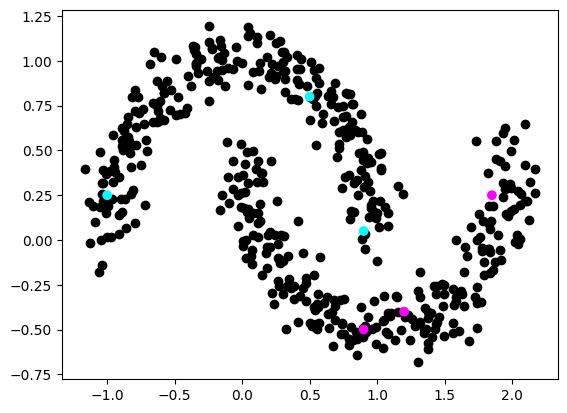

In [14]:
plt.scatter(u_x[:, 0], u_x[:, 1], c='black')
plt.scatter(l_x[:, 0], l_x[:, 1], c=l_y, cmap=plt.cm.cool)
plt.show()

In [15]:
decision_boundary

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

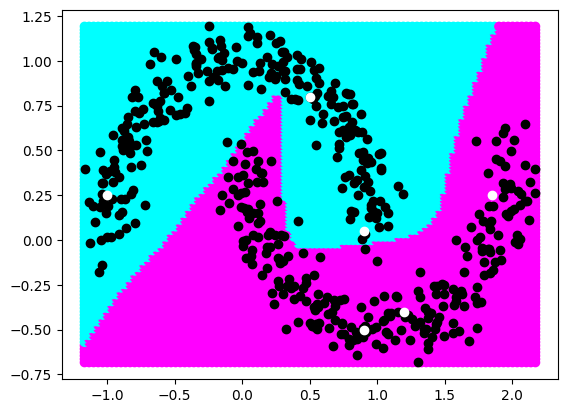

In [16]:
plt.scatter(A[:, 0], B[:, 0], c=decision_boundary, cmap=plt.cm.cool)
plt.scatter(u_x[:, 0], u_x[:, 1], c='black')
plt.scatter(l_x[:, 0], l_x[:, 1], c='white')
plt.show()

In [17]:
614289**0.25

27.99581949022828

In [18]:
614289/28

21938.89285714286